In [8]:
import kagglehub
import pandas as pd
import os

# Download dataset
path = kagglehub.dataset_download("amitabhajoy/bengaluru-house-price-data")
print("Path to dataset files:", path)

# Load into pandas
csv_path = os.path.join(path, "Bengaluru_House_Data.csv")
df = pd.read_csv(csv_path)

print(df.head())


100%|██████████| 195k/195k [00:00<00:00, 215kB/s]

Extracting files...
Path to dataset files: C:\Users\Bharti\.cache\kagglehub\datasets\amitabhajoy\bengaluru-house-price-data\versions\2
              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [10]:
# Create a copy to work on, keeping the original data safe
df_cleaned = df.copy()

# 1. Drop the 4 columns as we discussed
df_cleaned = df_cleaned.drop(['area_type', 'society', 'availability', 'balcony'], axis='columns')

# 2. Drop rows with missing values
df_cleaned = df_cleaned.dropna()

# 3. Clean the 'size' column and create a new 'bhk' column
df_cleaned['bhk'] = df_cleaned['size'].apply(lambda x: int(x.split(' ')[0]))
df_cleaned = df_cleaned.drop('size', axis='columns')

# 4. Clean the 'total_sqft' column
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df_cleaned['total_sqft'] = df_cleaned['total_sqft'].apply(convert_sqft_to_num)
df_cleaned = df_cleaned.dropna()

# Display the head of the cleaned dataframe to see the result
print("DataFrame after dropping columns and cleaning:")
print(df_cleaned.head())
print("\nNew shape of the DataFrame:", df_cleaned.shape)

DataFrame after dropping columns and cleaning:
                   location  total_sqft  bath   price  bhk
0  Electronic City Phase II      1056.0   2.0   39.07    2
1          Chikka Tirupathi      2600.0   5.0  120.00    4
2               Uttarahalli      1440.0   2.0   62.00    3
3        Lingadheeranahalli      1521.0   3.0   95.00    3
4                  Kothanur      1200.0   2.0   51.00    2

New shape of the DataFrame: (13200, 5)


In [11]:
import numpy as np

# We'll work with the df_cleaned DataFrame from the previous step
df_featured = df_cleaned.copy()

# 1. Create the 'price_per_sqft' feature. This is a key metric in real estate.
# Note: The price is in Lakhs (100,000 INR), so we multiply to get the actual price.
df_featured['price_per_sqft'] = df_featured['price']*100000 / df_featured['total_sqft']

# 2. Examine the 'location' column. Many locations only appear once.
# We'll group these rare locations into a category called 'other'.
location_stats = df_featured['location'].value_counts(ascending=False)
locations_less_than_10 = location_stats[location_stats<=10]
df_featured.location = df_featured.location.apply(lambda x: 'other' if x in locations_less_than_10 else x)

# 3. Remove logical outliers.
# For example, a 3-bedroom apartment with only 400 sq. ft. is highly unlikely.
# We'll remove properties where the square feet per bedroom is less than 300.
df_featured = df_featured[~(df_featured.total_sqft / df_featured.bhk < 300)]

# 4. Remove statistical outliers using the standard deviation.
# For each location, we'll remove properties that are beyond one standard deviation
# of the average price_per_sqft for that location.
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df_final = remove_pps_outliers(df_featured)

# Let's check the new shape and see the first few rows of our final, clean dataset
print("Shape after removing outliers:", df_final.shape)
print("\nFinal clean DataFrame:")
print(df_final.head())

Shape after removing outliers: (10245, 6)

Final clean DataFrame:
               location  total_sqft  bath  price  bhk  price_per_sqft
0   Devarachikkanahalli      1250.0   2.0   44.0    3     3520.000000
1   Devarachikkanahalli      1250.0   2.0   40.0    2     3200.000000
2   Devarachikkanahalli      1200.0   2.0   83.0    2     6916.666667
3   Devarachikkanahalli      1170.0   2.0   40.0    2     3418.803419
4   Devarachikkanahalli      1425.0   2.0   65.0    3     4561.403509


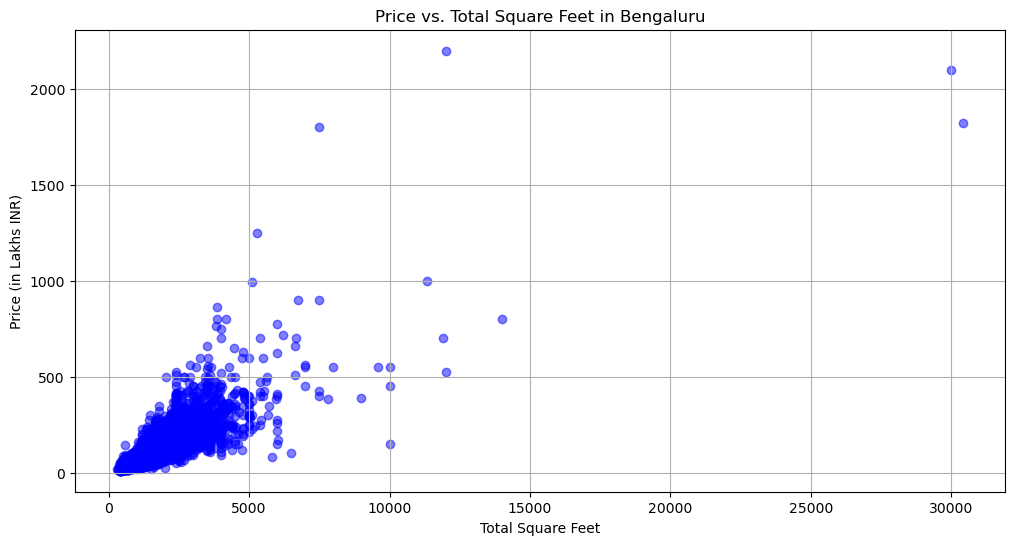

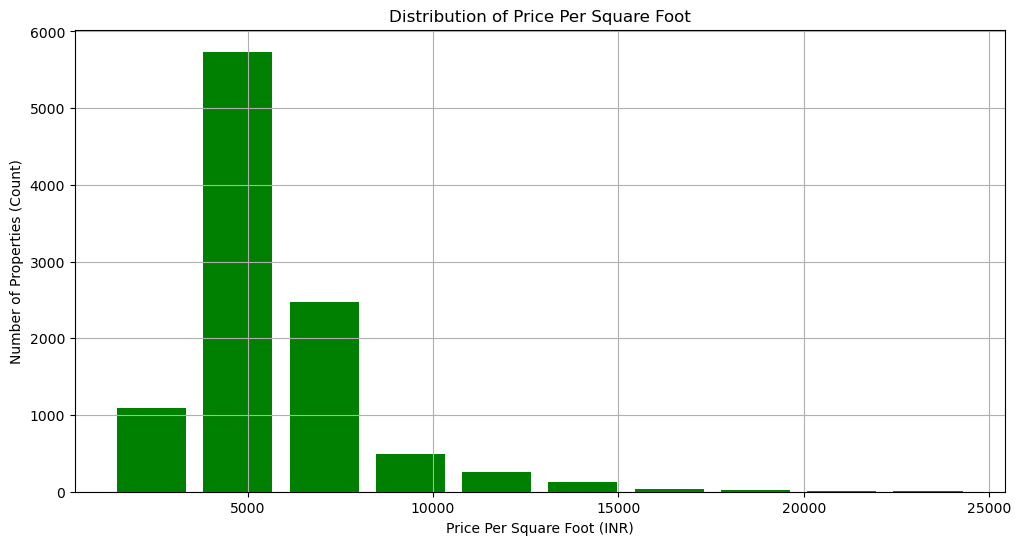

In [15]:
import matplotlib.pyplot as plt
import matplotlib

# Set some default settings for our plots for better readability
matplotlib.rcParams["figure.figsize"] = (12, 6)

# --- Plot 1: Scatter Plot of Price vs. Total Square Feet ---
# This plot helps us visually confirm the relationship between property size and price.
plt.figure(1)
plt.scatter(df_final.total_sqft, df_final.price, color='blue', alpha=0.5)
plt.xlabel("Total Square Feet")
plt.ylabel("Price (in Lakhs INR)")
plt.title("Price vs. Total Square Feet in Bengaluru")
plt.grid(True)


# --- Plot 2: Histogram of Price Per Square Foot ---
# This shows us the distribution of our 'price_per_sqft' feature.
# A "normal" or bell-shaped distribution is often a good sign for machine learning models.
plt.figure(2)
plt.hist(df_final.price_per_sqft, rwidth=0.8, color='green')
plt.xlabel("Price Per Square Foot (INR)")
plt.ylabel("Number of Properties (Count)")
plt.title("Distribution of Price Per Square Foot")
plt.grid(True)


# This command displays all the plots we've created
plt.show()

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# We'll work with the df_final DataFrame from the previous step
df_model = df_final.copy()

# 1. PREPARE THE DATA: One-Hot Encoding for 'location'
# This creates a new binary (0 or 1) column for each location.
dummies = pd.get_dummies(df_model.location)
df_model = pd.concat([df_model, dummies.drop('other', axis='columns')], axis='columns')

# Now, create the final X (features) and y (target) for the model.
# X contains all the features the model will use to make a prediction.
X = df_model.drop(['location', 'price', 'price_per_sqft'], axis='columns')

# y is the target variable – what we want to predict.
y = df_model.price


# 2. SPLIT THE DATA into Training and Testing Sets
# We'll use 80% of the data for training and 20% for testing.
# random_state=10 ensures we get the same split every time we run the code.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


# 3. TRAIN AND EVALUATE the Linear Regression Model
# Create the model object
lr_model = LinearRegression()

# Train the model using our training data
lr_model.fit(X_train, y_train)

# Evaluate the model's accuracy on the test data using the R-squared score.
accuracy = lr_model.score(X_test, y_test)

print(f"Model Accuracy (R-squared score): {accuracy:.2f}")

Model Accuracy (R-squared score): 0.78


In [18]:
import numpy as np

# This function uses your trained model to predict the price
def predict_price(location, sqft, bath, bhk):
    """
    Predicts the price of a house based on its features.
    """
    # Find the specific column index for the given 'location'.
    # np.where() finds the index where the column name matches the location.
    try:
        loc_index = np.where(X.columns==location)[0][0]
    except IndexError:
        # This handles cases where the location was grouped into 'other'.
        print(f"Location '{location}' not found. It may be grouped under 'other'. Prediction will be based on general data.")
        loc_index = -1 # Sentinel value to indicate not found

    # Create a numpy array of zeros with the same number of columns as our training data 'X'.
    # This is the input format the model expects.
    x = np.zeros(len(X.columns))
    
    # Set the values for the basic features at their correct positions.
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    
    # If the location was found, set its corresponding column to 1 (this is the one-hot encoding step).
    if loc_index >= 0:
        x[loc_index] = 1
        
    # The model's predict method expects a 2D array, so we wrap our single input 'x' in brackets [].
    # The [0] at the end extracts the single predicted value from the result.
    predicted_price = lr_model.predict([x])[0]
    
    return predicted_price

In [ ]:
price_whitefield = predict_price('Whitefield', 1200, 2, 2)
print(f"Predicted Price for a 1200 sqft, 2 BHK in Whitefield: {price_whitefield:.2f} Lakhs")

In [ ]:
price_rajaji_nagar = predict_price('Rajaji Nagar', 1600, 3, 3)
print(f"Predicted Price for a 1600 sqft, 3 BHK in Rajaji Nagar: {price_rajaji_nagar:.2f} Lakhs")

In [19]:
price_other = predict_price('Yelahanka', 1400, 2, 2)
print(f"Predicted Price for a 1400 sqft, 2 BHK in Yelahanka: {price_other:.2f} Lakhs")

Predicted Price for a 1400 sqft, 2 BHK in Yelahanka: 71.53 Lakhs


C:\Users\Bharti\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
